In [1]:
import pandas as pd
import numpy as np
import re
# loading the sources files
from IPython.core.display import display, HTML
tp=pd.read_csv("20231211-Filtered-TPs.csv")
cim=pd.read_csv("20231130-CIM-report.csv")
sp1=pd.read_csv("20231211-SP1.csv")
#For future reference
leninitp=len(tp)
leninicim=len(cim)
leninisp1=len(sp1)



/tmp/ipykernel_1814/2677971196.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#Read third party, filter on AC division
tp.columns
tp.head()
tp[['TDPARTY_NAME','TDPARTY_ADDRESS','TDPARTY_POSTAL_CODE',"TDPARTY_CITY","TDPARTY_COUNTRY", 'TDPARTY_PROGRAM']]
# Filtrage uniquement sur les third party AC
display(HTML('<h1>Stats</h1>'))
display(HTML('<b>Third parties in licenses # : </b>'+str(leninitp)))
display(HTML('<b>Supplier in CIM # : </b>'+str(leninicim)))
display(HTML('<b>Supplier in SP1 # : </b>'+str(leninisp1)))


In [3]:
# The country file is used to provide a mapping to all country representation (language and typo). 
countries=pd.read_csv("countries.csv",index_col=0)
# Select the countries when there is a need to substitute
replacements=countries[countries.originalcountry!=countries.tobename]
# Convert the mapping adding some pattern to avoid unwanted replacement 
# (To avoid Airbus is replaced by Airbus Airbusa because us represent the coutry usa)
#replacements.originalcountry="[\\s^]"+replacements.originalcountry+"[\\s$]"
replacements.originalcountry=replacements.originalcountry
replacements.tobename=" "+replacements.tobename
# Replacement of countries to unifed representation (independant from tongue and typo)
replacements=replacements.set_index('originalcountry')
replacements.tobename=replacements.tobename.replace("\s","",regex=True)
# Converting to dict
replacements=replacements.tobename.to_dict()

# Create a single pattern doing all replacement to apply once on every line (for efficency)
rep = dict((re.escape(k), v) for k, v in replacements.items()) 
pattern = re.compile("|".join(rep.keys()))


/tmp/ipykernel_1814/1498682475.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  replacements.originalcountry=replacements.originalcountry
/tmp/ipykernel_1814/1498682475.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  replacements.tobename=" "+replacements.tobename


In [4]:
# This set the country in case where the county information is provided in the name of the thrid party
def deduceContryFromNameInformation(df,acronym,country):
    df.CountryCleansed=df.CountryCleansed.mask((df.CountryCleansed.isna()) & (df.NameCleansed.str.contains( "\\s"+acronym+"[\s]*")),country)
    df.NameCleansed=df.NameCleansed.str.replace("\\s"+acronym+"[\\s]*","",regex=True)
    return df
    
def removeFromName(df,toremove):
    df.NameCleansed=df.NameCleansed.str.replace("\\s"+toremove+"[\\s]*","",regex=True)
    return df

# Function to clean the name of the commany and creating a column for representation of name + country
def cleanCountryAndName(df):
    dftoreplace=df
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"sas","france")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"s\.a\.s","france")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"france","france")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"french","france")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"ltd","united kingdom")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"united kingdom","united kingdom")
    dftoreplace=deduceContryFromNameInformation(dftoreplace, "s\.l","spain")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"s\.l\.","spain")
    dftoreplace=deduceContryFromNameInformation(dftoreplace, "slu","spain")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"spanish","spain")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"turkish*","turkey")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"german*","germany")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"gmbh*","germany")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"deutschland*","germany")
    dftoreplace=deduceContryFromNameInformation(dftoreplace, "germany*","germany")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"belgium*","belgium")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"belgian","belgium")
    dftoreplace=deduceContryFromNameInformation(dftoreplace, "luxembourg","luxembourg")

    
    
    dftoreplace.CountryCleansed=dftoreplace.CountryCleansed.mask((dftoreplace.CountryCleansed.isna()) & (dftoreplace.NameCleansed.str.contains( "\\ssud ouest[\s]*")),"france")
    dftoreplace.CountryCleansed=dftoreplace.CountryCleansed.mask((dftoreplace.CountryCleansed.isna()) & (dftoreplace.NameCleansed.str.contains( "\\ssud-ouest[\s]*")),"france")    
    dftoreplace.CountryCleansed=dftoreplace.CountryCleansed.mask((dftoreplace.CountryCleansed.isna()) & (dftoreplace.NameCleansed.str.contains( "[\\s]*toulouse[\s]*")),"france")
    dftoreplace.CountryCleansed=dftoreplace.CountryCleansed.mask((dftoreplace.CountryCleansed.isna()) & (dftoreplace.NameCleansed.str.contains( "\\ssl[\s]*")),"spain")
    
    #Remove unrelevant terms from company name 
    dftoreplace.NameCleansed=dftoreplace.NameCleansed.str.replace("\\sprivate[\\s]*"," ",regex=True)

    for country in countries.originalcountry:
        dftoreplace=removeFromName(dftoreplace,country)
        
    # Clean the country name use only english"
    dftoreplace["CountryCleansed"].fillna("",inplace=True)
    dftoreplace["CountryCleansed"]=dftoreplace["CountryCleansed"].apply(lambda x:pattern.sub(lambda m: rep[re.escape(m.group(0))], x))
    dftoreplace["CountryCleansed"].replace(" ","",regex=True,inplace=True)
    dftoreplace["CountryCleansed"].replace("-","",regex=True,inplace=True)
    dftoreplace["NameCountryCleansed"]=dftoreplace.NameCleansed+ " " +dftoreplace["CountryCleansed"]
    return dftoreplace

In [5]:
sp1.columns


Index(['supp_no', 'supp_name', 'supp_address', 'supp_postal_code', 'supp_city',
       'supp_country_code', 'supp_country_name_en', 'supp_cage_code',
       'division', 'all_text'],
      dtype='object')

In [6]:
# We create a cleansed name in the TP referential referential

tp["indexcol"]=tp.index
#tp=tp[tp.LICENSE_DIVISION=="AC"]
print("Tp with no name",tp[tp.TDPARTY_NAME.isna()])
print("Tp with no country")
print(tp[tp.TDPARTY_COUNTRY.isna()]["TDPARTY_NAME"])
tp=tp[~tp.TDPARTY_NAME.isna()]
#Filtrage sur la division
tp.to_csv("tp-cleansed.csv")
tp["NameCleansed"]=tp.TDPARTY_NAME.str.lower()
tp["CountryCleansed"]=tp.TDPARTY_COUNTRY.str.lower()
tp["CleansedAddress"]=tp['TDPARTY_ADDRESS'] +" " + tp['TDPARTY_POSTAL_CODE'] +" "+ tp['TDPARTY_CITY']
tp["CleansedAddress"]=tp["CleansedAddress"].str.lower()
tp["usablename"]=True



display(HTML('<b>Unique third party name #:</b>'+str(len(tp["NameCleansed"].unique()))))
lenfintp=len(tp)
display(HTML('<b>Removed third party after cleansing #:</b>'+str(lenfintp-leninitp)))
tp.head()


tp=cleanCountryAndName(tp)

tp.loc[tp.CountryCleansed.isna(),"usablename"]=False

tp.NameCountryCleansed[611]


Tp with no name Empty DataFrame
Columns: [FILENAME, LICENSE_NBR, TDPARTY_NAME, TDPARTY_ROLE, TDPARTY_COUNTRY, TDPARTY_ADDRESS, TDPARTY_ARP_ID, ARP_needreview, TDPARTY_FLAG, LICENSE_DIVISION, LICENSE_PROGRAM, TDPARTY_CITY, TDPARTY_POSTAL_CODE, TDPARTY_PROGRAM, indexcol]
Index: []
Tp with no country
20                 ALTRAN Sud Ouest
86                 ALTRAN Sud Ouest
168                 FLIR System INC
301           Airbus Operations SAS
611                      Airbus SAS
                   ...             
8284                     AIRBUS SAS
8451      AIRBUS DEFENSE & SPACE SA
8534    AIRBUS DEFENCE AND SPACE SA
8535    AIRBUS DEFENCE AND SPACE SA
8582                     AIRBUS SAS
Name: TDPARTY_NAME, Length: 106, dtype: object


'airbus france'

In [7]:
# We create a cleansed name in the CIM referential
cim.columns
cim.head()
cim["index"]=cim.index
cim[['Name','Country Name','Street',"Zip code",'City','Country (Address)']]
cim=cim[~cim.Name.isna()]
cim["NameCleansed"]=cim.Name.str.lower()
cim["CountryCleansed"]=cim["Country Name"].str.lower()
cim["CleansedAddress"]= cim['Street']+" " +  cim['Street (continued)']+" " + cim['Zip code']+" " + cim['City']
cim["CleansedAddress"]=cim["CleansedAddress"].str.lower()
cim=cleanCountryAndName(cim)

print("Nombre de supplier name dans cim",len(cim["NameCleansed"].unique()))

cim.NameCountryCleansed


Nombre de supplier name dans cim 1809


0                         nortel networksy& co kg germany
1                     nortel networky verwaltungs germany
2       australian aerospace military maintenance pty ...
3                        eurocopter international belgium
4       acma, gesellschaft für flugzeuggestützte trage...
                              ...                        
1878    molim mobilien verwaltungsgesellschaft mbh & c...
1879                         eads- cassidian hq g germany
1880                          cassidian- hq unitedkingdom
1881                                 cassidian- hq france
1882           euro-art advanced radar technology germany
Name: NameCountryCleansed, Length: 1883, dtype: object

In [8]:
#Nettoyage des supplier name
sp1.columns
sp1["index"]=sp1.index
sp1=sp1[~sp1.supp_name.isna()]

sp1["NameCleansed"]=sp1.supp_name.str.lower()
sp1["CountryCleansed"]=sp1.supp_country_name_en.str.lower()
sp1["CleansedAddress"]=sp1['supp_address']+" " + sp1['supp_postal_code']+" " + sp1['supp_city']
sp1["CleansedAddress"]=sp1["CleansedAddress"].str.lower()
print("Nombre de supplier name dans sp1",len(sp1["NameCleansed"].unique()))
sp1=cleanCountryAndName(sp1)

sp1.NameCountryCleansed

Nombre de supplier name dans sp1 42930


0                        atis iberica derichebourg spain
1                                             jvd france
2                wolf gustav seil und drahtwerke germany
3                                         caillau france
4        gardner aerospace - derby limited unitedkingdom
                              ...                       
49046                aertec industrial engineering spain
49047                  alestis tecnobahia montajes spain
49048                     ultra precision sa switzerland
49049                            drosg & co. switzerland
49050                                     sapelem france
Name: NameCountryCleansed, Length: 49051, dtype: object

In [9]:
corpusname=pd.concat([cim.NameCountryCleansed,tp.NameCountryCleansed,sp1.NameCountryCleansed])
corpusname[0]




0    nortel networksy& co kg germany
0              entserv unitedkingdom
0    atis iberica derichebourg spain
Name: NameCountryCleansed, dtype: object

In [10]:
#Based on the corpus of name we create a matrix of association
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer(strip_accents="ascii")
features = vectorizer.fit(corpusname)

tpnamevect=vectorizer.transform(tp.NameCountryCleansed)
cimnamevect=vectorizer.transform(cim.NameCountryCleansed)
sp1namevect=vectorizer.transform(sp1.NameCountryCleansed)

# Renormalize so that if country is present twice in name and in country, it is counted only once

tpnamevect=(tpnamevect>0)*1
cimnamevect=(cimnamevect>0)*1
sp1namevect=(sp1namevect>0)*1



In [11]:
tp.NameCountryCleansed[14]

'capgemini india'

In [12]:
# We compute a list giving if two name are similar
from sklearn.metrics.pairwise import cosine_similarity


similaritycim=cosine_similarity(tpnamevect,cimnamevect)
similaritysp1=cosine_similarity(tpnamevect,sp1namevect)


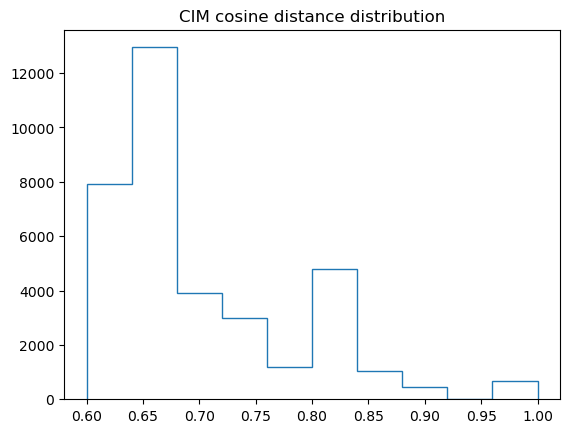

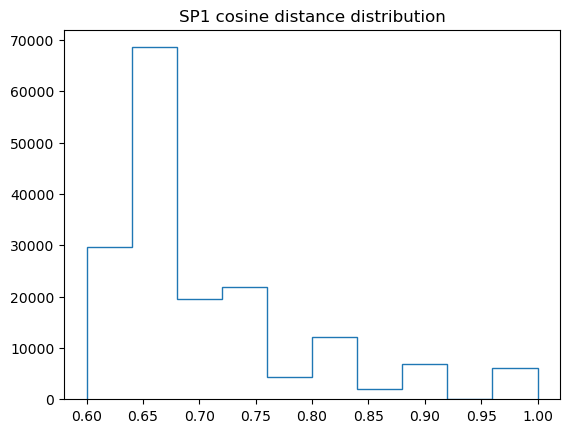

In [13]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

counts, bins =np.histogram(similaritycim,range=[.6,1])
plt.stairs(counts, bins)
plt.title("CIM cosine distance distribution")
plt.show()

counts, bins =np.histogram(similaritysp1,range=[.6,1])
plt.stairs(counts, bins)
plt.title("SP1 cosine distance distribution")
plt.show()
#hist

In [14]:
similarnamecim=np.where(similaritycim>.8)
similarnamesp1=np.where(similaritysp1>.8)
maxsimilarnamecim=np.argmax(similaritycim,axis=1)
maxsimilarnamesp1=np.argmax(similaritysp1,axis=1)



print("Exploration de CIM")
for i in range (1,2):
#    print(tp.NameCountryCleansed.iloc[similarnamecim[0][i]])
    print(tp.iloc[similarnamecim[0][i],2])
#    print(cim.NameCountryCleansed.iloc[similarnamecim[1][i]])
    print(cim.iloc[similarnamecim[1][i],3])
    print("----------")

print("===========")

print("Exploration de SP1")
for i in range (1,2):
    print(tp.NameCountryCleansed.iloc[similarnamesp1[0][i]])
    print(sp1.iloc[similarnamesp1[1][i],1])
    print("----------")



#from scipy import spatial
#np.where((tpnamevect.getrow(14).toarray()>0))
#cimnamevect.getrow(77).toarray()[0]

##spatial.distance.cosine(cimnamevect.getrow(14).toarray()[0], tpnamevect.getrow(77).toarray()[0])

#features.inverse_transform(tpnamevect.getrow(14))
#features.inverse_transform(cimnamevect.getrow(77))
#np.where(tpnamevect.getrow(14).toarray()>0)

Exploration de CIM
Airbus
Airbus Military France SAS
----------
Exploration de SP1
esg elektroniksystem-und-logistik-gmbh germany
ESG Elektroniksystem - und Logistik-GmbH
----------


In [15]:
sp1.iloc[similarnamesp1[1][i],:]


supp_no                                                             C3002
supp_name                        ESG Elektroniksystem - und Logistik-GmbH
supp_address                                                          NaN
supp_postal_code                                                      NaN
supp_city                                                             NaN
supp_country_code                                                      DE
supp_country_name_en                                              Germany
supp_cage_code                                                        NaN
division                                                              ADS
all_text                [ADS]; C3002; ESG Elektroniksystem - und Logis...
index                                                               36150
NameCleansed                     esg elektroniksystem - und logistik-gmbh
CountryCleansed                                                   germany
CleansedAddress                       

In [16]:
# Creates the proposal in CIM and SP1 correspondance
tp["idcim"]=""
tp["candidatscim"]=""
tp["probacim"]=""
tp["cleanednamecountrycim"]=""


tp["idsp1"]=""
tp["candidatssp1"]=""
tp["probasp1"]=""
tp["cleanednamecountrysp1"]=""

indexcim=tp.columns.get_loc("idcim")
indexcandidatscim=tp.columns.get_loc("candidatscim")
indexprobacim=tp.columns.get_loc("probacim")

# Affectation des proposition suppérieure à 0.9
for i in range(len(similarnamecim[0])):
    tp.iloc[similarnamecim[0][i],indexcim]=tp.iloc[similarnamecim[0][i],indexcim]+str(similarnamecim[1][i])+","
    tp.iloc[similarnamecim[0][i],indexcandidatscim]=tp.iloc[similarnamecim[0][i],indexcandidatscim]+cim.iloc[similarnamecim[1][i],3].replace("[,\n]"," ")+","

tp.head()
tpblank=tp[tp.idcim==""]
for index, row in tpblank.iterrows():
    idcim=maxsimilarnamecim[row.indexcol]
    proba = similaritycim[row.indexcol,idcim]
    if(proba>0.5):
        tp.at[row.indexcol,"idcim"]=idcim
        tp.at[row.indexcol,"candidatscim"]=cim.loc[idcim,"Name"]
        tp.at[row.indexcol,"cleanednamecountrycim"]=cim.loc[idcim,"NameCountryCleansed"]
        tp.at[row.indexcol,"probacim"]=similaritycim[row.indexcol,idcim]

indexsp1=tp.columns.get_loc("idsp1")
indexcandidatssp1=tp.columns.get_loc("candidatssp1")
for i in range(len(similarnamesp1[0])):
    tp.iloc[similarnamesp1[0][i],indexsp1]=tp.iloc[similarnamesp1[0][i],indexsp1]+str(similarnamesp1[1][i])+","
    tp.iloc[similarnamesp1[0][i],indexcandidatssp1]=tp.iloc[similarnamesp1[0][i],indexcandidatssp1]+sp1.iloc[similarnamesp1[1][i],1].replace("[,\n]"," ")+","

tpblank=tp[tp.idsp1==""]
for index, row in tpblank.iterrows():
    idsp1=maxsimilarnamesp1[row.indexcol]
    proba = similaritysp1[row.indexcol,idsp1]
    if(proba>0.5):
        tp.at[row.indexcol,"idsp1"]=idsp1
        tp.at[row.indexcol,"candidatssp1"]=sp1.loc[idsp1,"supp_name"]
        tp.at[row.indexcol,"cleanednamecountrysp1"]=sp1.loc[idsp1,"NameCountryCleansed"]
        tp.at[row.indexcol,"probasp1"]=similaritysp1[row.indexcol,idsp1]

tp.to_excel("ThirdParty-ProposedMatches.xlsx",float_format="%.2f")
suppliersansrefdanscim=tp[tp.idcim==""]
suppliersansrefdanscim=suppliersansrefdanscim[~suppliersansrefdanscim.NameCleansed.str.contains("armee")]
suppliersansrefdanscim=suppliersansrefdanscim[~suppliersansrefdanscim.NameCleansed.str.contains("armée")]
suppliersansrefdanscim=suppliersansrefdanscim[~suppliersansrefdanscim.NameCleansed.str.contains("army")]
suppliersansrefdanscim.TDPARTY_NAME.to_csv("suppliersansrefdanscim.csv")



In [17]:
tp[['NameCountryCleansed','cleanednamecountrysp1','probasp1','cleanednamecountrycim','probacim']][40:50]
#.loc[26,'NameCountryCleansed']
#tp[tp.CountryCleansed.str.contains("reich")]

,NameCountryCleansed,cleanednamecountrysp1,probasp1,cleanednamecountrycim,probacim
40,airbus defence and space limited unitedkingdom,,,,
41,alten technology germany,,,security technology services germany,0.57735
42,kuehne + nagel (ag & co.) kg germany,,,bilsoda& co.kg germany,0.612372
43,altran& co germany,,,bilsoda& co.kg germany,0.57735
44,sopra sterialimited india,,,,
45,gouvernement pour forces armées et autres serv...,,,,
46,quantas defence services australia,,,,
47,gfi informatique sa france,,,promologis sa france,0.57735
48,"accenture outsourcing service, s.a. spain","accenture,s.a. spain",0.707107,,
49,bull germany,. germany,0.707107,,


In [18]:
len(tp[tp.idcim==""].TDPARTY_NAME.unique())
pd.DataFrame(tp[tp.idcim==""].TDPARTY_NAME.unique()).to_csv("Supplier-AC-not-found.csv")

<Axes: xlabel='TDPARTY_FLAG_Cleansed'>

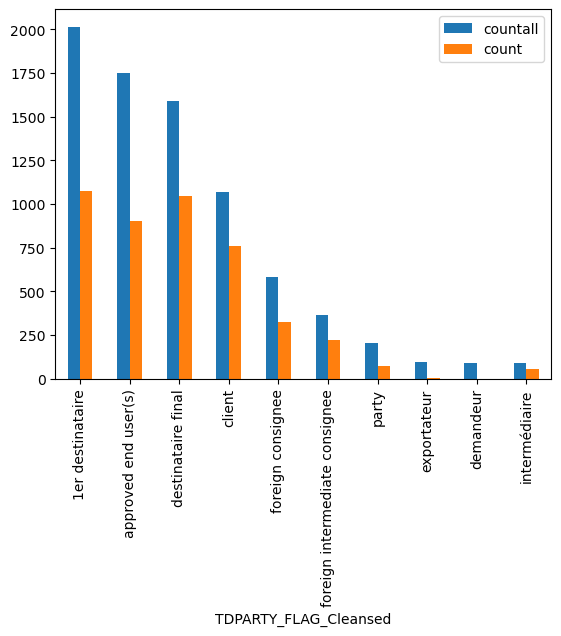

In [19]:
tp["TDPARTY_FLAG_Cleansed"]=tp.TDPARTY_FLAG.str.lower()
a=tp[tp.idcim==""].TDPARTY_FLAG_Cleansed.value_counts()
b=tp.TDPARTY_FLAG_Cleansed.value_counts()
m=b.to_frame().join(a.to_frame(),lsuffix='all')
m[0:10].plot.bar()

In [23]:
sp1["CleansedAddress"]
cim["CleansedAddress"]
tp["CleansedAddress"]

0        royal pavilion wellesley road gu11 1pz aldershot
1                      klarenstrecker damm 8  21684 stade
2       408 avenue des etats-unis bp 52010 31016 toulouse
3          livry-gargan-strasse 6 82256 fuerstenfeldbruck
4       po box b75-08 - 2 rond point emile dewoitine 3...
                              ...                        
8609    samlesbury aerodrome bb2 7lf balderstone, blac...
8610                           kreetslag 10 21129 hamburg
8611                                                  NaN
8612    unit 30, stakehill industrial park, finlan roa...
8613                           kreetslag 10 31129 hamburg
Name: CleansedAddress, Length: 8614, dtype: object